In [1]:
import os
import ahpy
import json
import math
import random
import hashlib
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt

from utils import Infiltrometro, ALL_FUNCTIONS, nse, points_distance, USO_SOLO_CLASS, SOIL_TYPES

from tqdm import tqdm
from xgboost import XGBRegressor
from shapely.geometry import Point
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from itertools import combinations, product, islice
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import QuantileTransformer

In [ ]:
OBS = gpd.read_file(r"D:/Mestrado/Trabalho Final/SIG/PotInfiltraçãoIDESisema.zip")

In [ ]:
OBS = gpd.read_file(r"D:/Mestrado/Trabalho Final/SIG/PotInfiltraçãoIDESisema.zip")                  # Raster com dados classificados pela condutividade
AHP = rxr.open_rasterio(r"D:\Mestrado\Trabalho Final\SIG\Classificacao_Infiltracao_MG_AHP.tif")     # Raster com dados classificados pelo método AHP
MIF = rxr.open_rasterio(r"D:\Mestrado\Trabalho Final\SIG\Classificacao_Infiltracao_MG_MIF.tif")     # Raster com dados classificados pelo método MIF

In [ ]:
layers = ["AD", "Urubu", "Taboão", "Sumidouro", "Rola Moça", "Pintado", "Jatobá", "Fubá", "Barreirinho"]

rasters = {
    "AHP": AHP,
    "MIF": MIF,
}

for key in [i for i in ALL_FUNCTIONS.keys()] + ['XGB', 'RF']:
    rasters[key] = rxr.open_rasterio(fr"D:\Mestrado\Trabalho Final\SIG\Classificacao_Infiltracao_{key}.tif")

In [6]:
types = ["OBS", "AHP", "MIF"] + [i for i in ALL_FUNCTIONS.keys()] + ['XGB', 'RF']

data = {
    "geometry": [],
}

for key in types:
    data[key] = []

for layer in layers:
    if layer == "AD":
        gdf = AD
    else:
        gdf = gpd.read_file(r"D:\Mestrado\Trabalho Final\SIG\subbacias2.gpkg", layer = layer)
    
    gdf_geom = gdf.to_crs("EPSG:31983").copy()
    geom = gdf_geom.geometry.values.union_all()
    data["geometry"].append(geom)
    
    for name, rast in tqdm(rasters.items(), desc=f"{layer} - Raster", total=len(rasters)):

        # Clipando o raster:
        clipped = rast.rio.clip([geom], drop=True)

        arr = clipped.squeeze().values
        arr = arr[(~np.isnan(arr)) & (arr >= 0)]

        mean   = np.mean(arr)
        median = np.median(arr)
        min    = np.min(arr)
        max    = np.max(arr)

        data[name].append({
            "subbacia": layer,
            "mean": mean,
            "median":median,
            "min": min,
            "max": max,
        })

# for tipo in tqdm(types, desc="Salvando", total=len(types)):
#     gdf = gpd.GeoDataFrame(data[tipo], geometry=data["geometry"], crs="EPSG:31983")
#     gdf.to_file(r"D:\Mestrado\Trabalho Final\SIG\subbacias.gpkg", layer = tipo)

Barreirinho - Raster: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it]


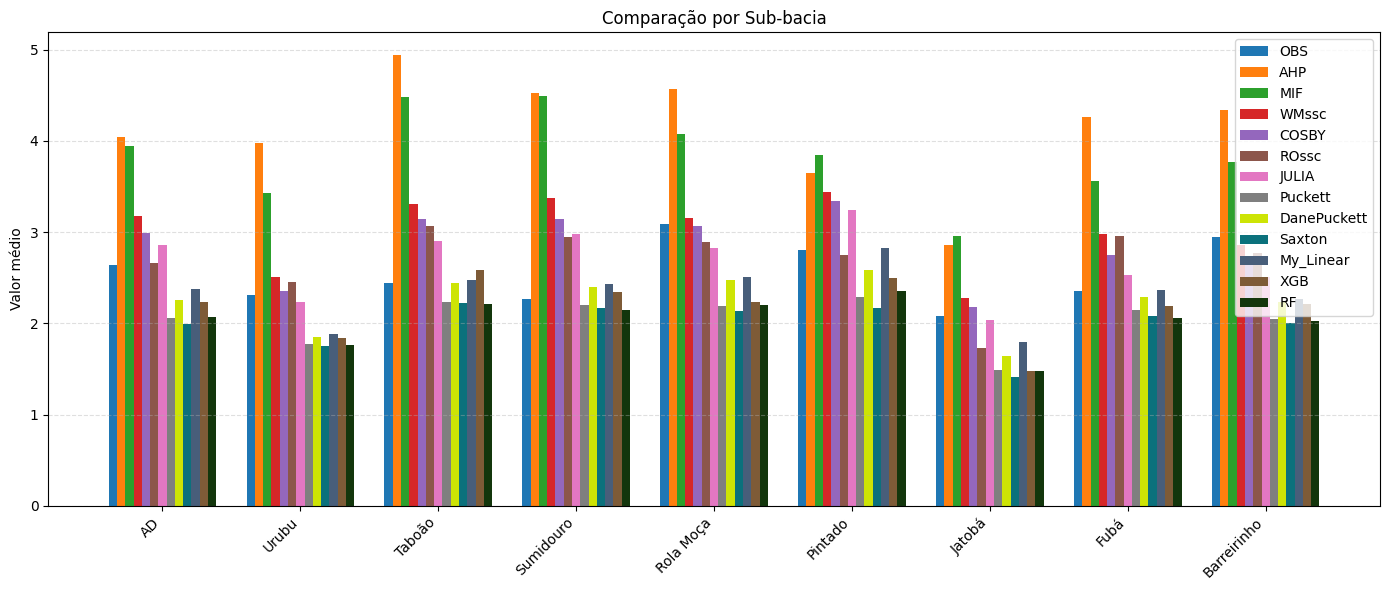

In [7]:
# Converter seu dicionário em DataFrame
# df = pd.DataFrame(data)
# df = df.reindex(layers)

# Número de grupos (sub-bacias)
n = len(layers)

# Número de categorias (OBS, AHP, MIF)
k = len(types)

# Largura de cada barra
width = 0.06

# Posições no eixo X
x = np.arange(n)

# Cores
colors = [
    "#1f77b4ff",  # azul
    "#ff7f0eff",  # laranja
    "#2ca02cff",  # verde
    "#d62728ff",  # vermelho
    "#9467bdff",  # roxo
    "#8c564bff",  # marrom
    "#e377c2ff",  # rosa
    "#7f7f7fff",  # cinza
    "#cde405ff",  # oliva
    "#0b717cff",  # ciano
    "#485e7aff",  # azul claro
    "#7e5b37ff",  # laranja claro
    "#13360cff"   # verde claro
]

# Criar gráfico
plt.figure(figsize=(14, 6))

# Plotar cada coluna deslocada no eixo X
for i, type in enumerate(types):
    values = []
    for layer in layers:
        dados = data[type]
        values.append(data[type][layers.index(layer)]["mean"])

    plt.bar(x - ((width*(k-1))/2) + (i*width), values, width, label=type, color=colors[i])

# plt.bar(x - width, df["OBS"], width, label="OBS", color="#1f77b4")
# plt.bar(x,         df["AHP"], width, label="AHP", color="#ff7f0e")
# plt.bar(x + width, df["MIF"], width, label="MIF", color="#2ca02c")

# Ajustes visuais
plt.xticks(x, layers, rotation=45, ha="right")
plt.ylabel("Valor médio")
plt.title("Comparação por Sub-bacia")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
# Comparações com o observado

erros_type = {}
for i, type in enumerate(types):
    if type == "OBS":
        continue
    
    print(f"Para o método {type}:")
    prevs = []
    obss = []
    for layer in layers:
        dados = data[type]
        value = data[type][layers.index(layer)]["mean"]
        value_obs = data['OBS'][layers.index(layer)]["mean"]

        erro = value_obs - value

        prevs.append(value)
        obss.append(value_obs)
        print(f"\tLayer {layer}: {erro:.2f}")
    print(f"\tCom RMSE de {(root_mean_squared_error(obss, prevs)):.2f}")

Para o método AHP:
	Layer AD: -1.41
	Layer Urubu: -1.67
	Layer Taboão: -2.50
	Layer Sumidouro: -2.26
	Layer Rola Moça: -1.49
	Layer Pintado: -0.84
	Layer Jatobá: -0.78
	Layer Fubá: -1.91
	Layer Barreirinho: -1.40
	Com RMSE de 1.67
Para o método MIF:
	Layer AD: -1.30
	Layer Urubu: -1.12
	Layer Taboão: -2.04
	Layer Sumidouro: -2.22
	Layer Rola Moça: -0.99
	Layer Pintado: -1.04
	Layer Jatobá: -0.88
	Layer Fubá: -1.20
	Layer Barreirinho: -0.83
	Com RMSE de 1.37
Para o método WMssc:
	Layer AD: -0.54
	Layer Urubu: -0.19
	Layer Taboão: -0.87
	Layer Sumidouro: -1.11
	Layer Rola Moça: -0.07
	Layer Pintado: -0.64
	Layer Jatobá: -0.20
	Layer Fubá: -0.63
	Layer Barreirinho: 0.08
	Com RMSE de 0.59
Para o método COSBY:
	Layer AD: -0.35
	Layer Urubu: -0.04
	Layer Taboão: -0.70
	Layer Sumidouro: -0.87
	Layer Rola Moça: 0.01
	Layer Pintado: -0.53
	Layer Jatobá: -0.10
	Layer Fubá: -0.40
	Layer Barreirinho: 0.21
	Com RMSE de 0.46
Para o método ROssc:
	Layer AD: -0.03
	Layer Urubu: -0.14
	Layer Taboão: -0